This notebook is to help learners like myself to understand how we can use time series forecasting to solve business problems. The data and scenario are from Udacity's course on time series forecasting which is a part of the predictive analytics nanodegree. You can find more info regarding the course [here](https://www.udacity.com/course/predictive-analytics-for-business-nanodegree--nd008).


## Scenario:

You recently started working as a Business Analyst for a company that creates and sells video games. Your manager discusses a business problem with you and tasks you to come up with a solution.

The problem at hand is that the company's ordering method is not as efficient as it should be. The company is having a hard time trying to predict demand so that it can match ordering supplies to meet the need of its customers. The company doesn't want to bloat the demand estimation and end up with piles of unused stock. Similary they don't want to underestimate demand and run the risk of losing customers to competition. 

Your manager has tasked you to forecast monthly sales data in order to synchronize supply with demand, aid in decision making that will help build a competitive infrastructure and measure company performance. You, the business analyst, are assigned to help your manager run the numbers through a time series forecasting model.

You’ve been asked to provide a forecast for the next 4 months of sales and report your findings.


### Note: 

During the course of this notebook I will use multiple time series model. I will try to explain them as simply as possible. To understand it further and in more detail I will post links to materials that I have found really helpful.

Initially I had solved the problems using Alteryx. I have posted the screenshot of the workflow below for anyone that might be interested is using Alteryx to create a workflow. 

In [1]:
import pandas as pd
import seaborn as sns
import os
from IPython.display import Image

C:\Users\hamza\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


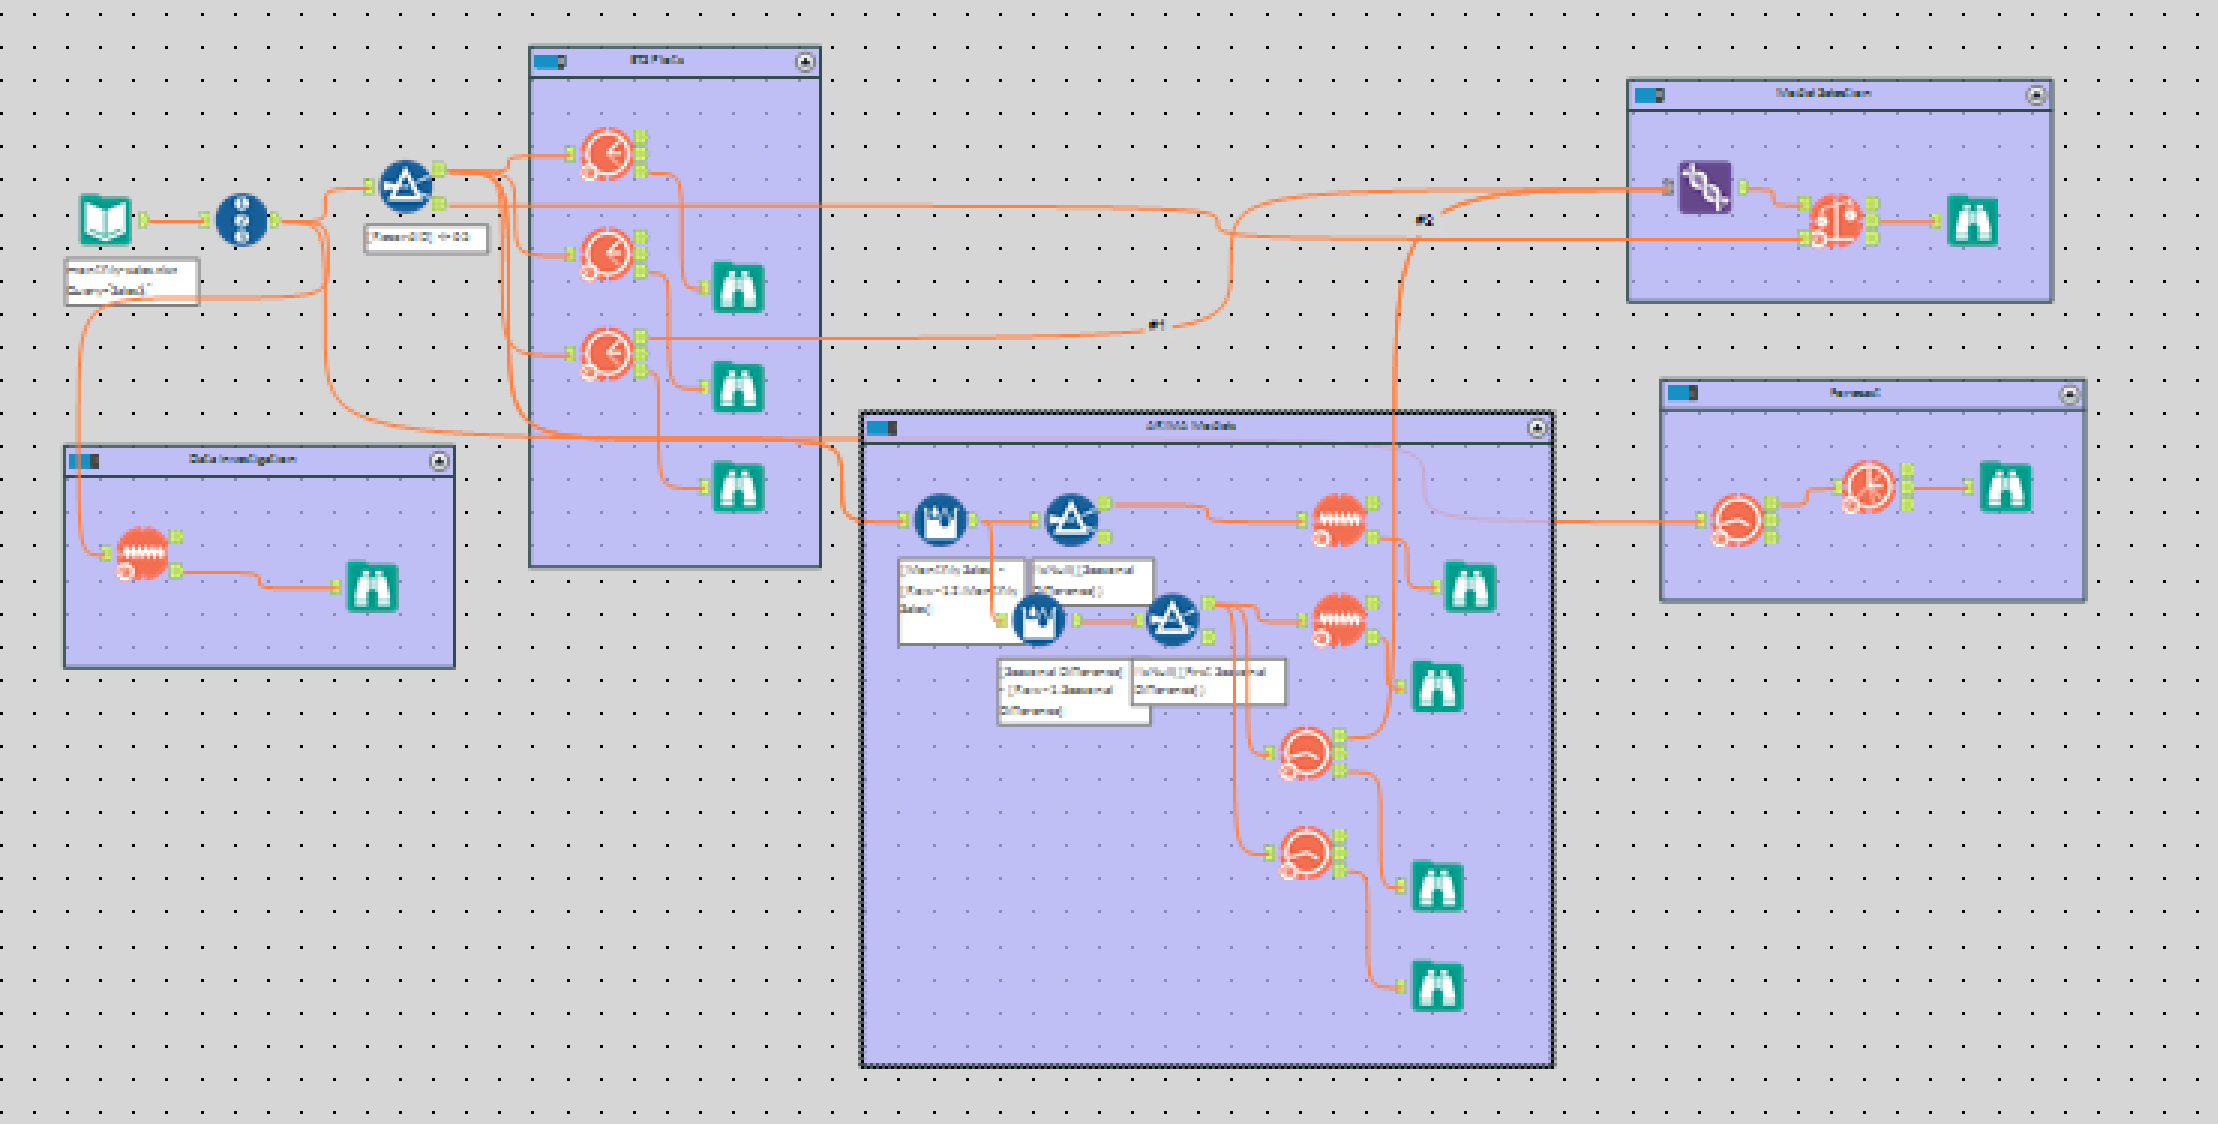

In [2]:
Image(os.listdir()[2])

In [3]:
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'alteryx_workflow_time_series_notebook.PNG',
 'monthly-sales.xlsx',
 'README.md',
 'Time_series.ipynb']

In [4]:
data = pd.read_excel(os.listdir()[3])

In [5]:
data.head()

,Month,Monthly Sales
0,2008-01,154000
1,2008-02,96000
2,2008-03,73000
3,2008-04,51000
4,2008-05,53000


In [6]:
print(data.shape)
print(data.columns)
print(data.isnull().any())

(69, 2)
Index(['Month', 'Monthly Sales'], dtype='object')
Month            False
Monthly Sales    False
dtype: bool


The first question that arises is how do I know by looking at the data that a time series model will be a good choice. Well there are certain characteristics that you will look for in your data before you go about applying models:

- Is the data in sequential intervals. Simply put is there a pattern to the dates. In our dataset we have data for each month. There is an order to it. If we have data at random from let's say Jan, Feb, Aug, Nov, we couldn't use it in our forecast model. 

- Order matters. It's an extension to our previous point. If were to switch 2 and 3rd row the data will change. It won't have the same meaning. It won't make any logical sense since the month of Feb cannot come before Jan of the same year.

- Single data points. Again this ties to the idea of data making logical sense. For the month of Jan, I cannot have an aggregate sales of 100 and 200. That doesn't sense.

So our data does hold true for all of the above points and hence it is a viable input. 

In [7]:
data['Month'] = pd.to_datetime(data['Month'])

In [8]:
data.head()

,Month,Monthly Sales
0,2008-01-01,154000
1,2008-02-01,96000
2,2008-03-01,73000
3,2008-04-01,51000
4,2008-05-01,53000


In [9]:
data.dtypes

Month            datetime64[ns]
Monthly Sales             int64
dtype: object

In [10]:
data.set_index(data['Month'], drop = True, inplace = True)

In [11]:
data.head()

,Month,Monthly Sales
Month,,
2008-01-01,2008-01-01,154000
2008-02-01,2008-02-01,96000
2008-03-01,2008-03-01,73000
2008-04-01,2008-04-01,51000
2008-05-01,2008-05-01,53000


In [12]:
data.drop(columns = ['Month'], inplace = True)

In [13]:
data.head()

,Monthly Sales
Month,
2008-01-01,154000
2008-02-01,96000
2008-03-01,73000
2008-04-01,51000
2008-05-01,53000


Let us now visualise our data and get a feel of how it looks like.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

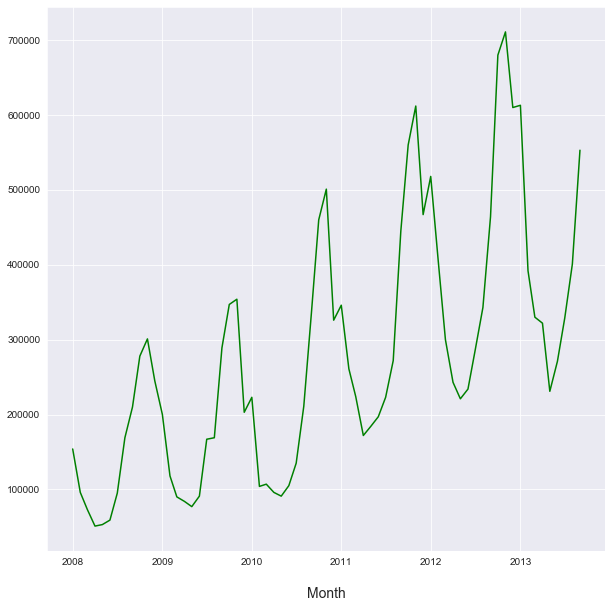

In [14]:
plt.figure(figsize = (10,10))
sns.set_style('darkgrid')
plt.plot(data, color = 'green')
plt.xlabel('Month', fontsize = 14, labelpad = 20)
plt.show()

Let's say you aren't well aware of the various time series models and decide to use simplistic methods to forecast the data. The first method you decide to use is the average method where you average all the past values and assign the average value as the forecasted value. 

A important question here is that how will you know how good your forecast is?. You don't have any future data to reference against. Since we are tasked with forecating the sales for the next 4 periods, let us create a test set that contains the last 4 months of the data. That way we can predict on these months and then calculate how far off our model really is. 

In [15]:
test = data.iloc[65:,:]

In [16]:
test

,Monthly Sales
Month,
2013-06-01,271000
2013-07-01,329000
2013-08-01,401000
2013-09-01,553000


We have to make sure the model we train on does not contain the test set values.

In [17]:
train = data.iloc[0:65]

#remember when indexing using numbers, the last value of the range is included.

In [18]:
train.shape

(65, 1)

Let us make our first predictions.

In [19]:
series_values = train['Monthly Sales'].values.tolist()
average_method_prediction = []

for x in range(4):
    average = np.mean(series_values)
    average_method_prediction.append(average)
    series_values.append(average)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

It makes sense that all the values are the same. Now let us see how good our predictions are. 

In [20]:
from sklearn.metrics import mean_squared_error

average_method_mse = mean_squared_error(test['Monthly Sales'], average_method_prediction)
average_method_rmse = average_method_mse ** (1/2)


In [21]:
print(average_method_mse)
print(average_method_rmse)

25245053017.751488
158886.91896361855


Let us make a df where we can store the error comparisons of the different models we will use, just to see our progression from a simple model to a complex model and how it affects error values. 

In [22]:
model_comparison = pd.DataFrame(columns = ['Model Name', 'MSE', 'RMSE'])

In [23]:
model_comparison

,Model Name,MSE,RMSE


In [24]:
model_comparison = model_comparison.append({'Model Name' : 'Average Method', 'MSE' : average_method_mse, 'RMSE' : average_method_rmse}, ignore_index=True)

In [25]:
model_comparison

,Model Name,MSE,RMSE
0,Average Method,2.524505e+10,158886.918964


It is safe to say our forecast values are way off. To be specific off by almost 160000. Now that's not good is it. We think a little and decided to use another approach. What if I just assigned the forecast value to the same as the most recent period's value. The rationale is that there won't be that much of a difference in the sales from one month to the other. This approach is called the naive method. So let us try using that model.

In [26]:
train.tail()

,Monthly Sales
Month,
2013-01-01,613000
2013-02-01,392000
2013-03-01,330000
2013-04-01,322000
2013-05-01,231000


So the first prediction would be the value 231000. Since all of the rest are predictions as well, the value will pretty much be the same. You can already sense how wrong all of our approaches are but let us continue to make sure we document the error values. 

In [27]:
naive_method_predictions = [231000, 231000, 231000, 231000]

naive_method_mse = mean_squared_error(test['Monthly Sales'], naive_method_predictions)
naive_method_rmse = naive_method_mse ** (1/2)

print(naive_method_mse)
print(naive_method_rmse)

35947000000.0
189596.94090359157


In [28]:
model_comparison.append({'Model Name' : 'Naive Method', 'MSE' : naive_method_mse, 'RMSE' : naive_method_rmse}, ignore_index=True)

,Model Name,MSE,RMSE
0,Average Method,2.524505e+10,158886.918964
1,Naive Method,3.594700e+10,189596.940904


Well apparently we seem to be getting worse with our predictions. This isn't good. There are other apporaches as well such as moving average method and seasonal naive method, but you get the picture already. 

So why is it that our values are so far off. Let's look at our plot again.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

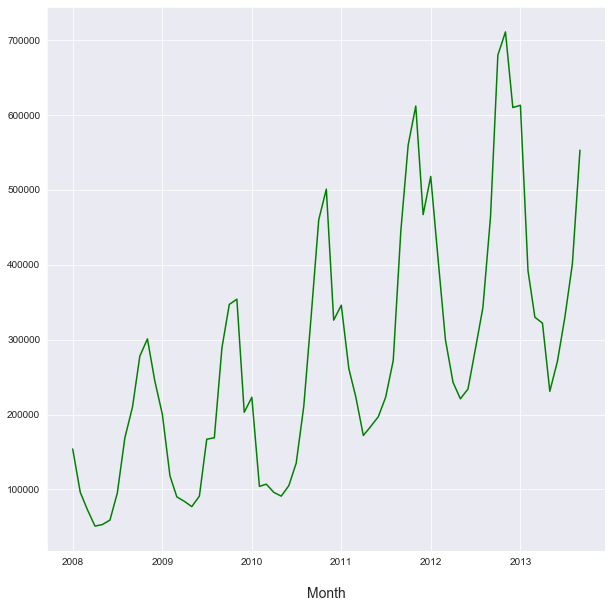

In [29]:
plt.figure(figsize = (10,10))
sns.set_style('darkgrid')
plt.plot(data, color = 'green')
plt.xlabel('Month', fontsize = 14, labelpad = 20)
plt.show()

We can tell that there is a certain trend to the overall data. If I were to draw a line through it, it would show an upward trend. Similar we can see that there seasonality in out data. What is seasonality?. A trend tends to repeat itself over a specific amount of time. Based on our intervals, it can be weekly, monthly or yearly. In our data, the seasonality occurs every 12 months, where we see a spike in sales. If you are a hotel, you might see spike in sales every summer during vacation periods. If you sell jackets, witner season will bring in seasonality in sales. 

Considering both these factors, shouldn't it be logical to include trend and seasonality in our forecasts as well?. Hence let us start moving towards more complex models, that do take into account seasonality and trends. There are two models we will be working with, Exponential Smoothing and ARIMA.

For most time series models we would first need to deconstruct out time series. In simple words, viewing the trend and seasonality portion of the data as seperate graphs. 

### Time Series Plots:

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose 

In [31]:
decomposition = seasonal_decompose(data)

<IPython.core.display.Javascript object>

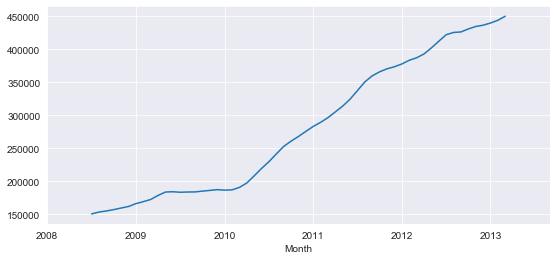

In [54]:
trend = decomposition.trend
trend.plot(legend = False, figsize = (9,4))
plt.show()

<IPython.core.display.Javascript object>

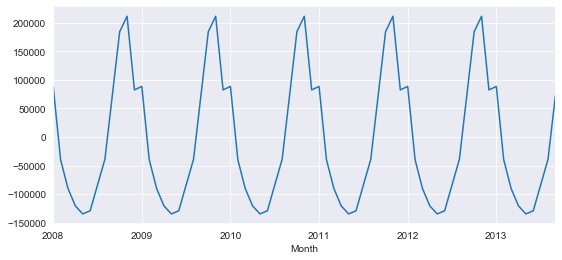

In [55]:
seasonal = decomposition.seasonal
seasonal.plot(legend = False, figsize = (9,4))
plt.show()

<IPython.core.display.Javascript object>

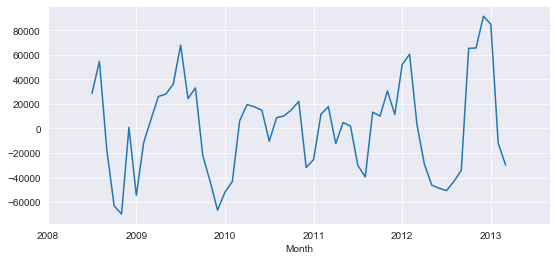

In [56]:
residual = decomposition.resid
residual.plot(legend = False, figsize = (9,4))
plt.show()